In [1]:
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
from dwave.system.composites import TilingComposite
from dimod import SampleSet,BQM, ExactSolver

from orang import OrangSampler

import numpy as np

import tqdm


from importlib import reload

from bqmtools import graphtools

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [2]:
import sys
sys.path.append("../freezeout/")


In [3]:
from freeze import Tiling
# package is freeze, function is tiling

/home/csel-ima2019-31/.ima-wave/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):

100%|██████████| 54/54 [37:36<00:00, 41.55s/it]

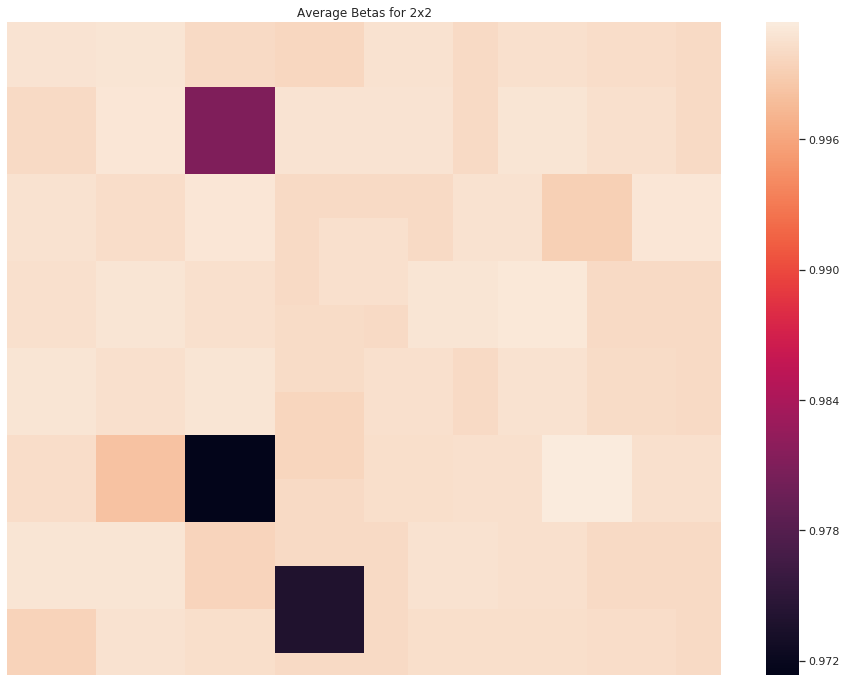

/home/csel-ima2019-31/.ima-wave/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):

 35%|███▌      | 11/31 [09:59<18:14, 54.70s/it]

In [ ]:
examples = [[2,2],[3,2],[2,3],[3,3]]

for example in examples:
    rows = example[0]
    cols = example[1]
    R = Tiling(sub_m=rows, sub_n=cols)
    # this is the 2 by 1 tiling 

    _ = R.generate_ran_r_tiles()
    # generating tiles?

    sample_size=500
    res = R.sample_tiling(num_reads=sample_size)
    # sampling the tiles

    graphtools.draw_bqm_on_chimera(R.bqm, node_size=20)
    # R.bqm is our solution
    # chimera is the unit cell (there are 2 kinds..)


    beta_tiles = []
    #for i in range(len(R.tiles)):
    for i in tqdm.tqdm(range(len(R.tiles))):
        orang_sampler = OrangSampler()
        # this is the simulation

        learning_rate = 0.01

        tile = R.tiles[i]
        # initializing tile
        qpu_energies = tile.qpu_tile_energy(res, R.tiling_composite)
        # getting energy states
        qpu_mean_en, qpu_std_en, qpu_stderr_en = R.compute_energy_stats(qpu_energies)
        # computing stats: mean, standard deviation, and standard error
        # print(f'QPU energies = {res.record.energy}')


        betas = [1]
        for i in range(sample_size):
            new_bqm = R._update_bqm(tile.bqm, betas[-1])

            resp = orang_sampler.sample(new_bqm, num_reads=sample_size)

        #     print(f'Orang energies = {resp.record.energy[:5]}')

            mean_en, var_en, stderr_en = R.compute_energy_stats(resp.record.energy)
            # calling the output by the left hand side

        #     print("qpu_mean - mean = {}".format(qpu_mean_en - mean_en))

        #     print(f'delta term = {(learning_rate / max(1, var_en)) * (qpu_mean_en - mean_en)}')
        #    beta1 = betas[-1] - (learning_rate / max(1, var_en)) * np.sign(qpu_mean_en - mean_en)
            beta2 = betas[-1] - (learning_rate / max(1, var_en)) * (qpu_mean_en - mean_en)
            # this is 'newtons method' the optimization technique 
            # connection with quant. computer and my simulation on my computer


            betas.append(beta2)
        beta_tiles.append(betas)

    #Calculate average beta for each tile
    average_tile_beta = []
    for i in range(len(beta_tiles)):
        average = sum(beta_tiles[i])/len(beta_tiles[i])
        average_tile_beta.append(average)

    #Create a phonebook between tiles and cells.
    #Maybe a dictionary would work better.
    cell_tile_association = []
    for i in range(len(R.tiles)):
        cell_tile_association.append(R.tiles[i].which_cells())

    #Use this new phonebook to assign tile average beta to the proper cell
    cell_average_beta = [0]*256
    #print(cell_average_beta)
    for j in range(256):
        #print(cell_index)
        foundTile = False

        for i in range(len(cell_tile_association)):
            if j in cell_tile_association[i]:
                foundTile = True
                tile_index = i

        if(not foundTile):
            cell_average_beta[j] = 1.0
        else:
            cell_average_beta[j] = average_tile_beta[tile_index]

    cell_average_beta = np.array(cell_average_beta)
    cell_average_beta = np.reshape(cell_average_beta,(16,16))

    ax = sns.heatmap(cell_average_beta).set_title("Average Betas for %dx%d"%(rows,cols))
    plt.show()


#### Check J sign convention
#### Variable elimination order
#### check on beta_{i+1} 
Etarget = E(beta) + [dE/dbeta] dbeta

dbeta = (Etarget- E(beta))/[dE/dbeta]

dE/dbeta = specific heat/beta^2 = energy variance